In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
import matplotlib.pyplot as plt
%matplotlib inline


%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/World ATM and GDP Data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13205 entries, 0 to 13204
Data columns (total 10 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Country Name                                                            13202 non-null  object 
 1   Country Code                                                            13200 non-null  object 
 2   Time                                                                    13200 non-null  float64
 3   Time Code                                                               13200 non-null  object 
 4   Automated teller machines (ATMs) (per 100,000 adults) [FB.ATM.TOTL.P5]  13200 non-null  object 
 5   GDP (current US$) [NY.GDP.MKTP.CD]                                      13200 non-null  object 
 6   GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                               13200 

In [4]:
#Rename Columns
df.rename(columns = {   "Time": "Year",                        
                        "Country Name":"Country",
                        "Automated teller machines (ATMs) (per 100,000 adults) [FB.ATM.TOTL.P5]":"ATM_per100K",  
                        "GDP (current US$) [NY.GDP.MKTP.CD]": "GDP",
                        "GDP per capita (current US$) [NY.GDP.PCAP.CD]": "GDP_percapita",
                        "GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]":"GDP_percapita_growth",
                        "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":"GDP_growth_annualperc",
                        "Mobile cellular subscriptions (per 100 people) [IT.CEL.SETS.P2]":"mobile_subscr_per100"},
                        inplace=True)

#drop null
df = df.drop(['Time Code', 'Country Code'], axis=1)
df = df.drop([13203, 13204]) #drop strings in the Year Column
df = df.replace(to_replace = '..', value=np.nan, regex=False) #replace all the blank values with nan
df.dropna(subset=['Year', 'ATM_per100K', 'mobile_subscr_per100'], inplace = True)
#ATM_Per100 = 3350 rows --> remove Nan from Mobile --> 2319 rows

#Casting
df['Year'] = df['Year'].astype(int)
cols = df.columns.drop(['Year','Country'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [5]:
df.describe() #df_small.describe() #df_medium.describe() df_large.describe()

,Year,ATM_per100K,GDP,GDP_growth_annualperc,GDP_percapita,GDP_percapita_growth,mobile_subscr_per100
count,3219.000000,3219.000000,3.207000e+03,3197.000000,3207.000000,3197.000000,3219.000000
mean,2011.462877,41.579199,2.508705e+12,3.877104,13127.424552,2.441561,88.853627
std,4.329151,44.309421,8.185900e+12,4.810665,18081.585484,4.695686,43.668405
min,2004.000000,0.000000,1.817050e+08,-62.075920,128.336613,-62.378077,0.209503
25%,2008.000000,7.689702,1.190084e+10,1.936922,1801.139158,0.652025,57.781332
50%,2012.000000,30.329917,7.030716e+10,3.911693,5354.236859,2.476708,93.742067
75%,2015.000000,58.173131,7.677231e+11,6.022513,15190.626755,4.384897,118.127134
max,2019.000000,324.170505,8.635707e+13,123.139555,118823.648369,121.779543,345.324522


In [6]:
#Create quantile column by GDP per capita
df['quantile'] = pd.qcut(df['GDP'], q=[0, .25, .75, 1], labels=['small', 'medium', 'large'])
df_small = df[df['quantile']=='small']
df_medium = df[df['quantile']=='medium']
df_large = df[df['quantile']=='large']
#Create quantile column by GDP per capita
df['quantile_percapita'] = pd.qcut(df['GDP_percapita'], q=[0, .25, .75, 1], labels=['small', 'medium', 'large'])
df_small = df[df['quantile_percapita']=='small']
df_medium = df[df['quantile_percapita']=='medium']
df_large = df[df['quantile_percapita']=='large']

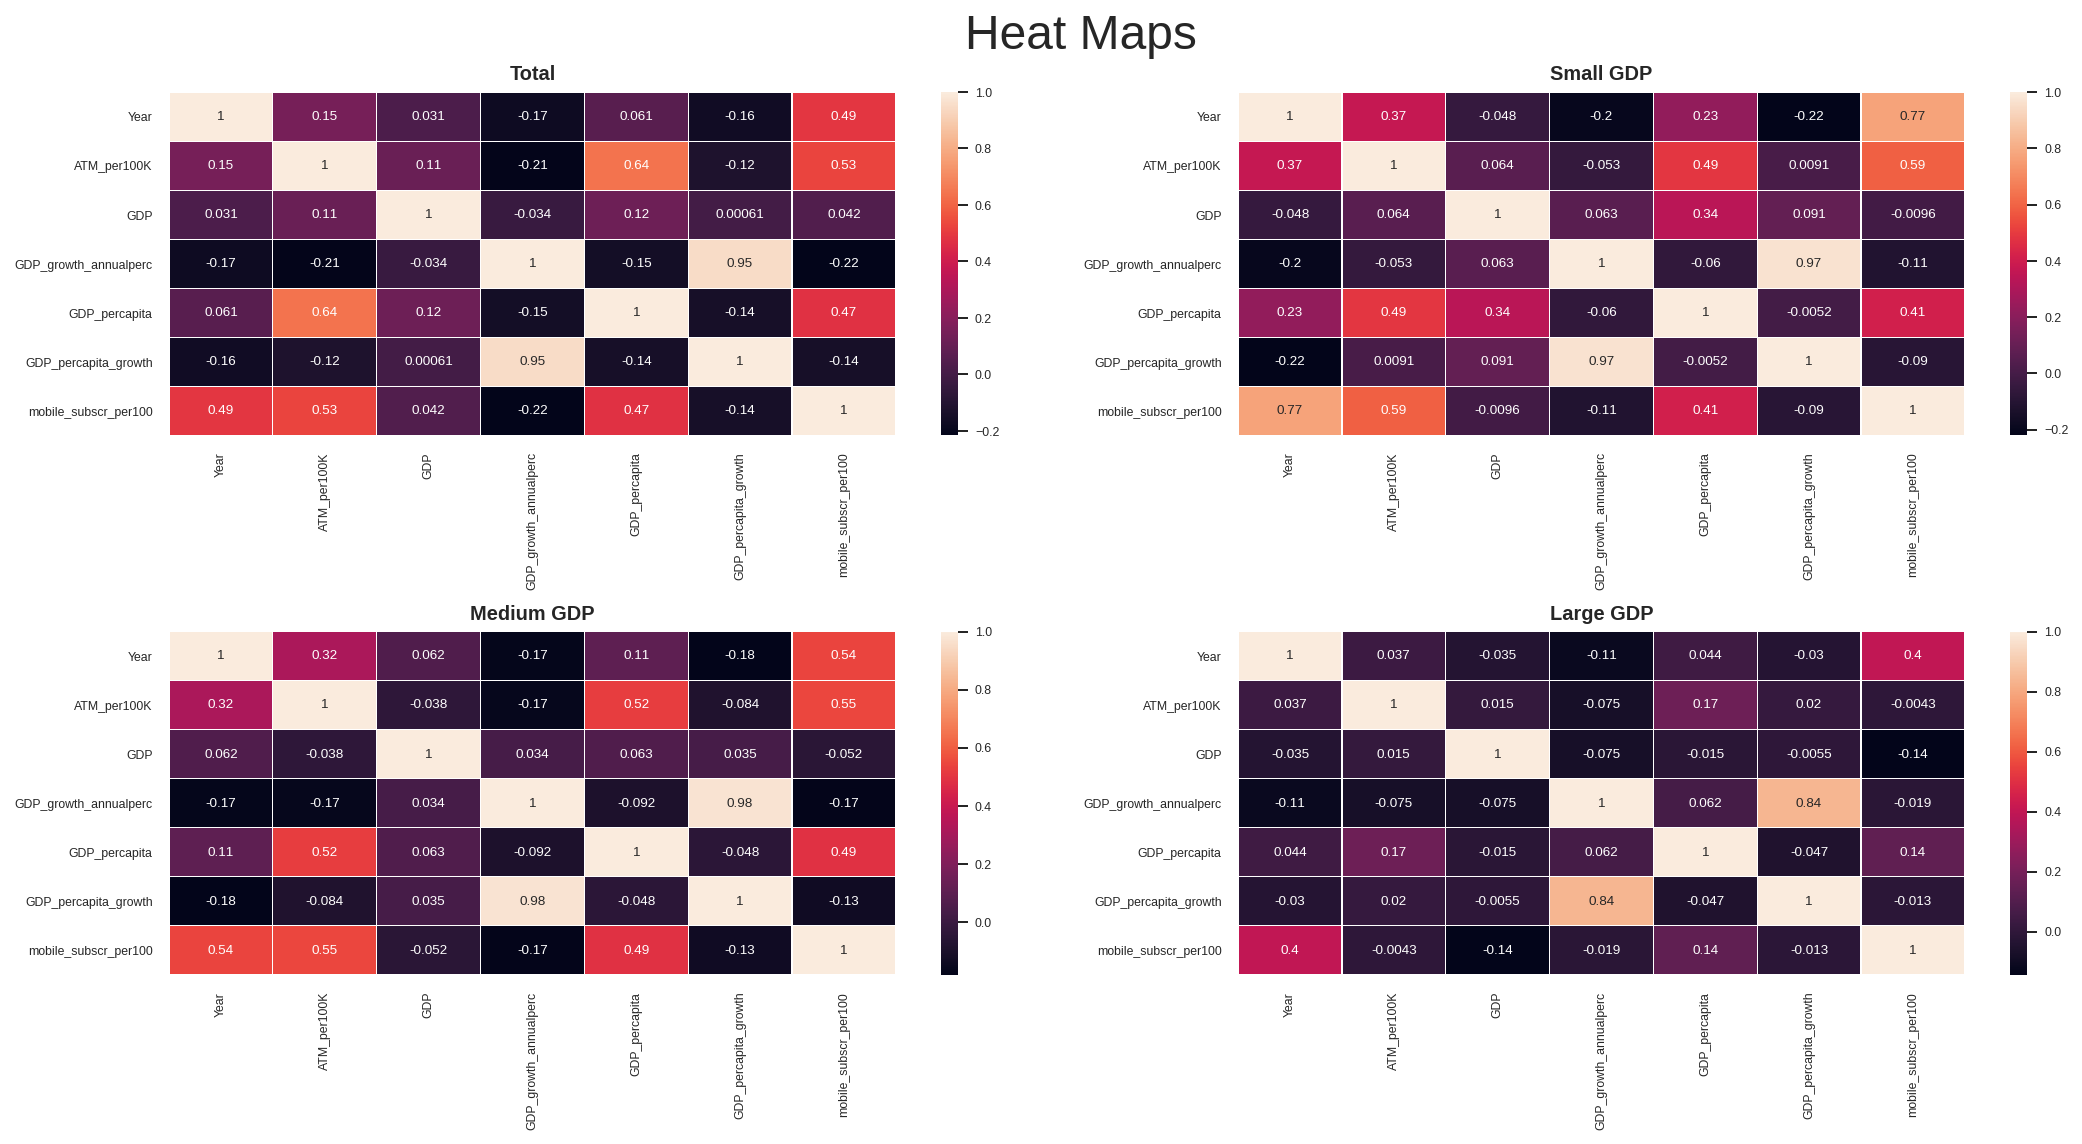

In [7]:
#Heat Maps for correlation
sns.set_context("paper", font_scale = .7, rc={"grid.linewidth": 3})
f = plt.figure(figsize=(15, 8))
_ = f.suptitle('Heat Maps', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    ax = sns.heatmap(df.corr(), annot = True, linewidths=.05)
    _= ax.set_title('Total', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax0 = f.add_subplot(gs[0, 1])
    ax0 = sns.heatmap(df_small.corr(), annot = True, linewidths=.05)
    _= ax0.set_title('Small GDP', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax1 = f.add_subplot(gs[1, 0])
    ax1 = sns.heatmap(df_medium.corr(), annot = True, linewidths=.05)
    _= ax1.set_title('Medium GDP', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[1, 1])
    ax2 = sns.heatmap(df_large.corr(), annot = True, linewidths=.05)
    _= ax2.set_title('Large GDP', weight='bold', size=10)
    
plt.subplots_adjust(wspace=2,hspace=1)
f.tight_layout()    
# _= plt.savefig('Heat_Map')

In [8]:
def best_fit(x, y):
    xbar = sum(x)/len(x)
    ybar = sum(y)/len(y)
    n = len(x) 

    num = sum([xi*yi for xi,yi in zip(x, y)]) - n * xbar * ybar
    den = sum([xi**2 for xi in x]) - n * xbar**2

    b = num / den
    a = ybar - b * xbar

    return a, b

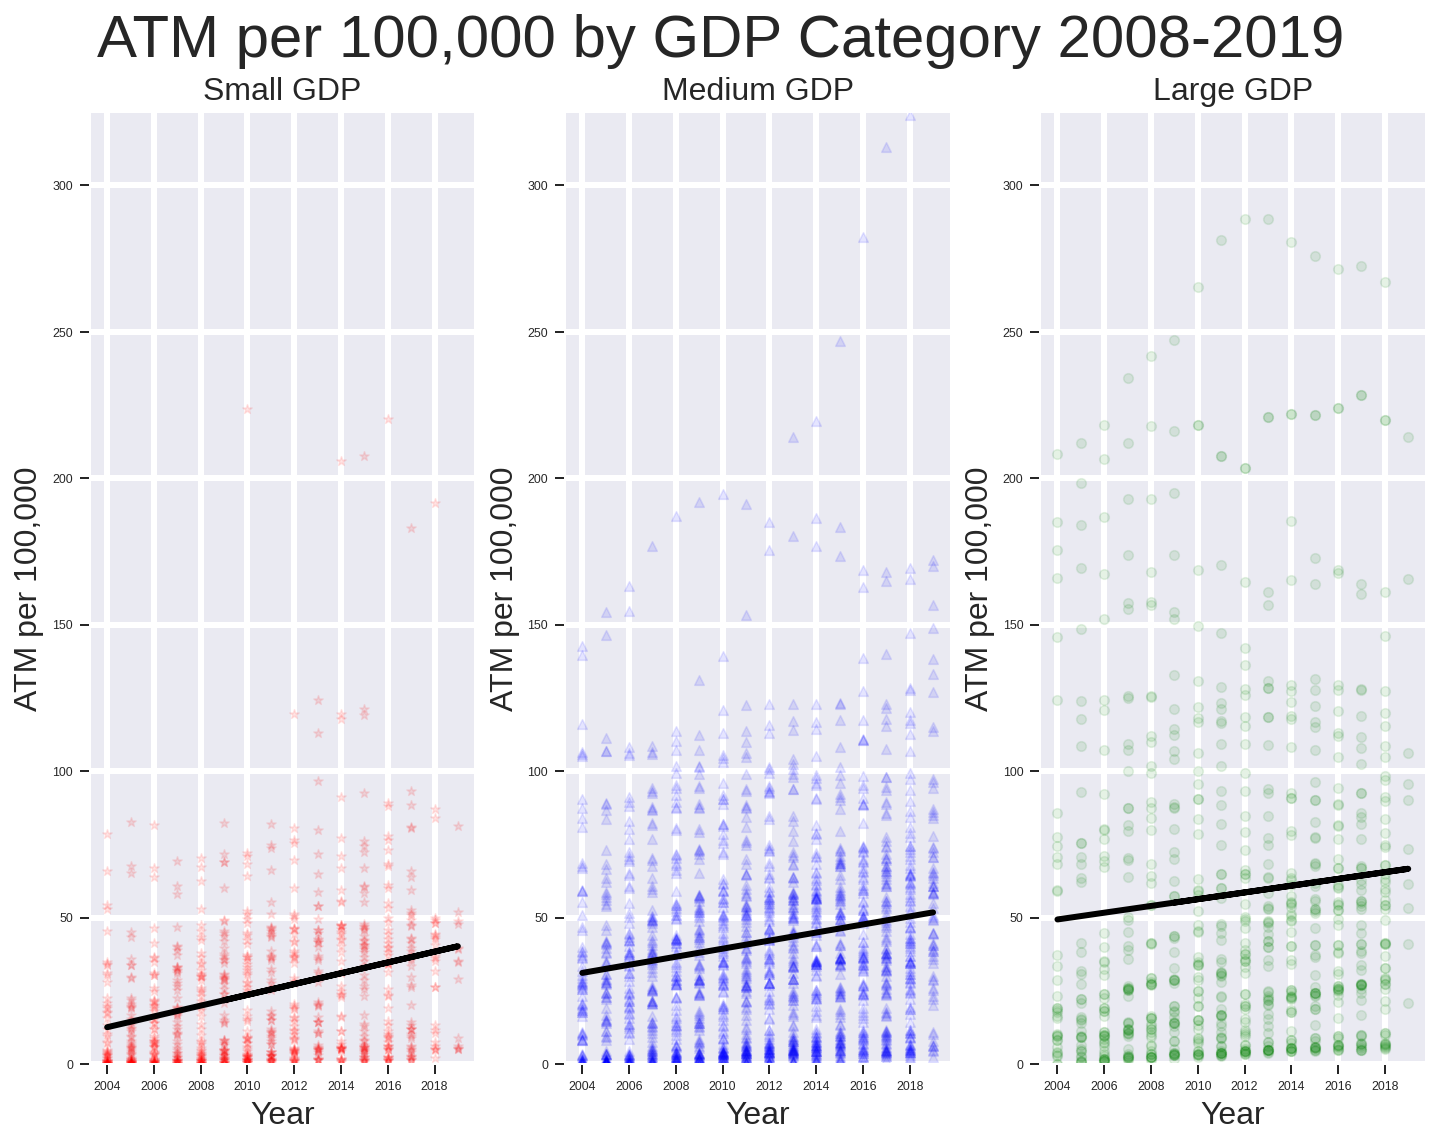

In [9]:
#Scatter Plot - ATMs by GDP Total
fig = plt.figure(figsize=(10,8))
_ = fig.suptitle('ATM per 100,000 by GDP Category 2008-2019', size=30)

x0 = df[df['quantile'] == 'small']['Year']
y0 = df[df['quantile'] == 'small']['ATM_per100K']
x1 = df[df['quantile'] == 'medium']['Year']
y1 = df[df['quantile'] == 'medium']['ATM_per100K']
x2 = df[df['quantile'] == 'large']['Year']
y2 = df[df['quantile'] == 'large']['ATM_per100K']

ax1 = fig.add_subplot(1,3,1)
_ = ax1.scatter(x0, y0, marker = '*', alpha = .1, c='red', label="Small GDP" )
_ = ax1.set_ylim([0, 325])
_ = ax1.set_xlabel('Year', fontsize = 16)
_ = ax1.set_ylabel('ATM per 100,000', fontsize = 16)
_ = ax1.set_title('Small GDP', fontsize = 16)
a, b = best_fit(x0, y0)
yfit0 = [a + b * xi for xi in x0]
_= ax1.plot(x0, yfit0, c='black', lw='3.0')

ax2 = fig.add_subplot(1,3,2)
_ = ax2.scatter(x1, y1, marker = '^', alpha = .1, c='blue', label="Medium GDP")
_ = ax2.set_ylim([0, 325])
_ = ax2.set_xlabel('Year', fontsize = 16)
_ = ax2.set_ylabel('ATM per 100,000', fontsize = 16)
_ = ax2.set_title('Medium GDP', fontsize = 16)
a, b = best_fit(x1, y1)
yfit1 = [a + b * xi for xi in x1]
_= ax2.plot(x1, yfit1, c='black', lw='3.0')

ax3 = fig.add_subplot(1,3,3)
_ = ax3.scatter(x2, y2, marker = 'o', alpha = .1, c='green', label="Large GDP")
_ = ax3.set_ylim([0, 325])
_ = ax3.set_xlabel('Year', fontsize = 16)
_ = ax3.set_ylabel('ATM per 100,000', fontsize = 16)
_ = ax3.set_title('Large GDP', fontsize = 16)
a, b = best_fit(x2, y2)
yfit2 = [a + b * xi for xi in x2]
_= ax3.plot(x2, yfit2, c='black', lw='3.0')

plt.subplots_adjust(wspace=0.2,hspace=.4)
plt.tight_layout()
# plt.savefig('ATM per 100,000 by GDP Category Scatterplot')

<ipython-input-10-12a2e9e67ed4>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


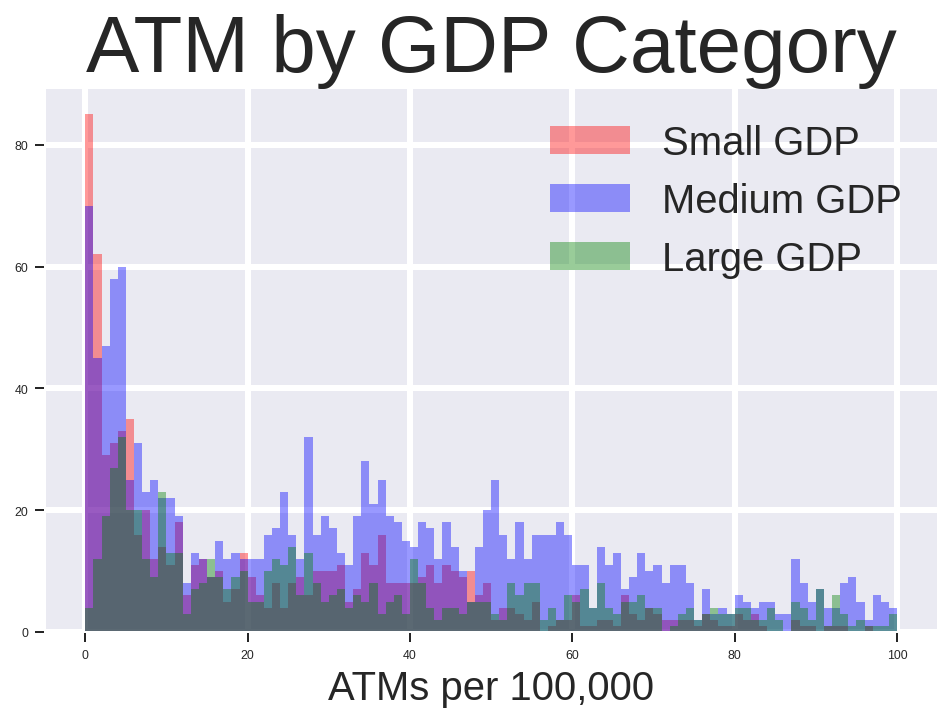

In [10]:
# ATM Availability by GDP category
fig = plt.figure(figsize=(8,5))
_= plt.title('ATM by GDP', size = 24)

y0 = df[df['quantile'] == 'small']['ATM_per100K']
y1 = df[df['quantile'] == 'medium']['ATM_per100K']
y2 = df[df['quantile'] == 'large']['ATM_per100K']

bins = 100
range=[0, 100]

ax = fig.add_subplot()
_= ax.hist(y0, bins, alpha=0.4, range=range, color='red', label='Small GDP')
_= ax.hist(y1, bins, alpha=0.4, range=range, color='blue', label='Medium GDP')
_= ax.hist(y2, bins, alpha=0.4, range=range, color='green', label='Large GDP')
_= ax.set_xlabel('ATMs per 100,000', fontsize = 20)
_= ax.set_title('ATM by GDP Category', fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
_= plt.legend(loc='upper right', fontsize=20)
# _= plt.savefig('ATM per 100,000 by GDP Quantile Combined Histogram', bbox_inches='tight')

<ipython-input-25-b492352b415a>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


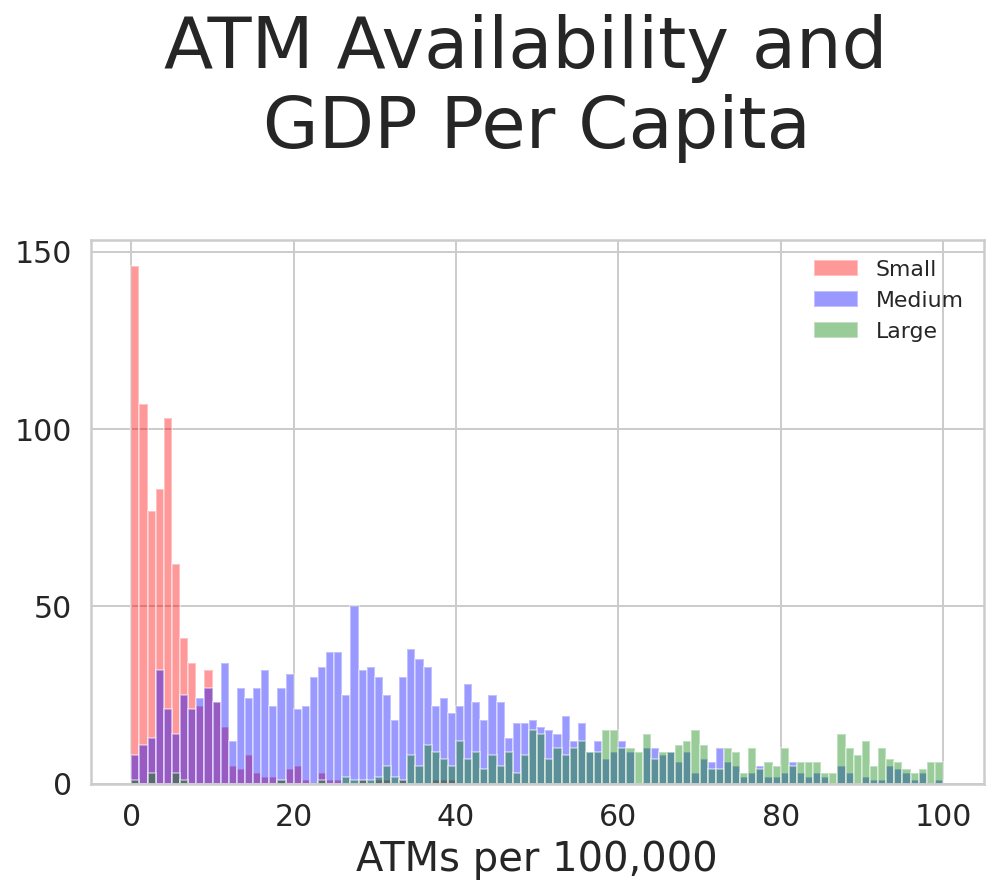

In [25]:
#ATM Availability by GDP per Capita
fig = plt.figure(figsize=(8,5))
_= plt.title('ATM by GDP', size = 24)

y0 = df[df['quantile_percapita'] == 'small']['ATM_per100K']
y1 = df[df['quantile_percapita'] == 'medium']['ATM_per100K']
y2 = df[df['quantile_percapita'] == 'large']['ATM_per100K']

bins = 100
range=[0, 100]

ax = fig.add_subplot()
_= ax.hist(y0, bins, alpha=0.4, range=range, color='red', label='Small')
_= ax.hist(y1, bins, alpha=0.4, range=range, color='blue', label='Medium')
_= ax.hist(y2, bins, alpha=0.4, range=range, color='green', label='Large')
_= ax.set_xlabel('ATMs per 100,000', fontsize = 20)
_= ax.set_title('ATM Availability and \n GDP Per Capita \n', fontsize=36)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
_= plt.legend(loc='upper right', fontsize=11)
# _= plt.savefig('ATM per 100,000 by GDP Per Capita Quantile Combined Histogram', bbox_inches='tight')

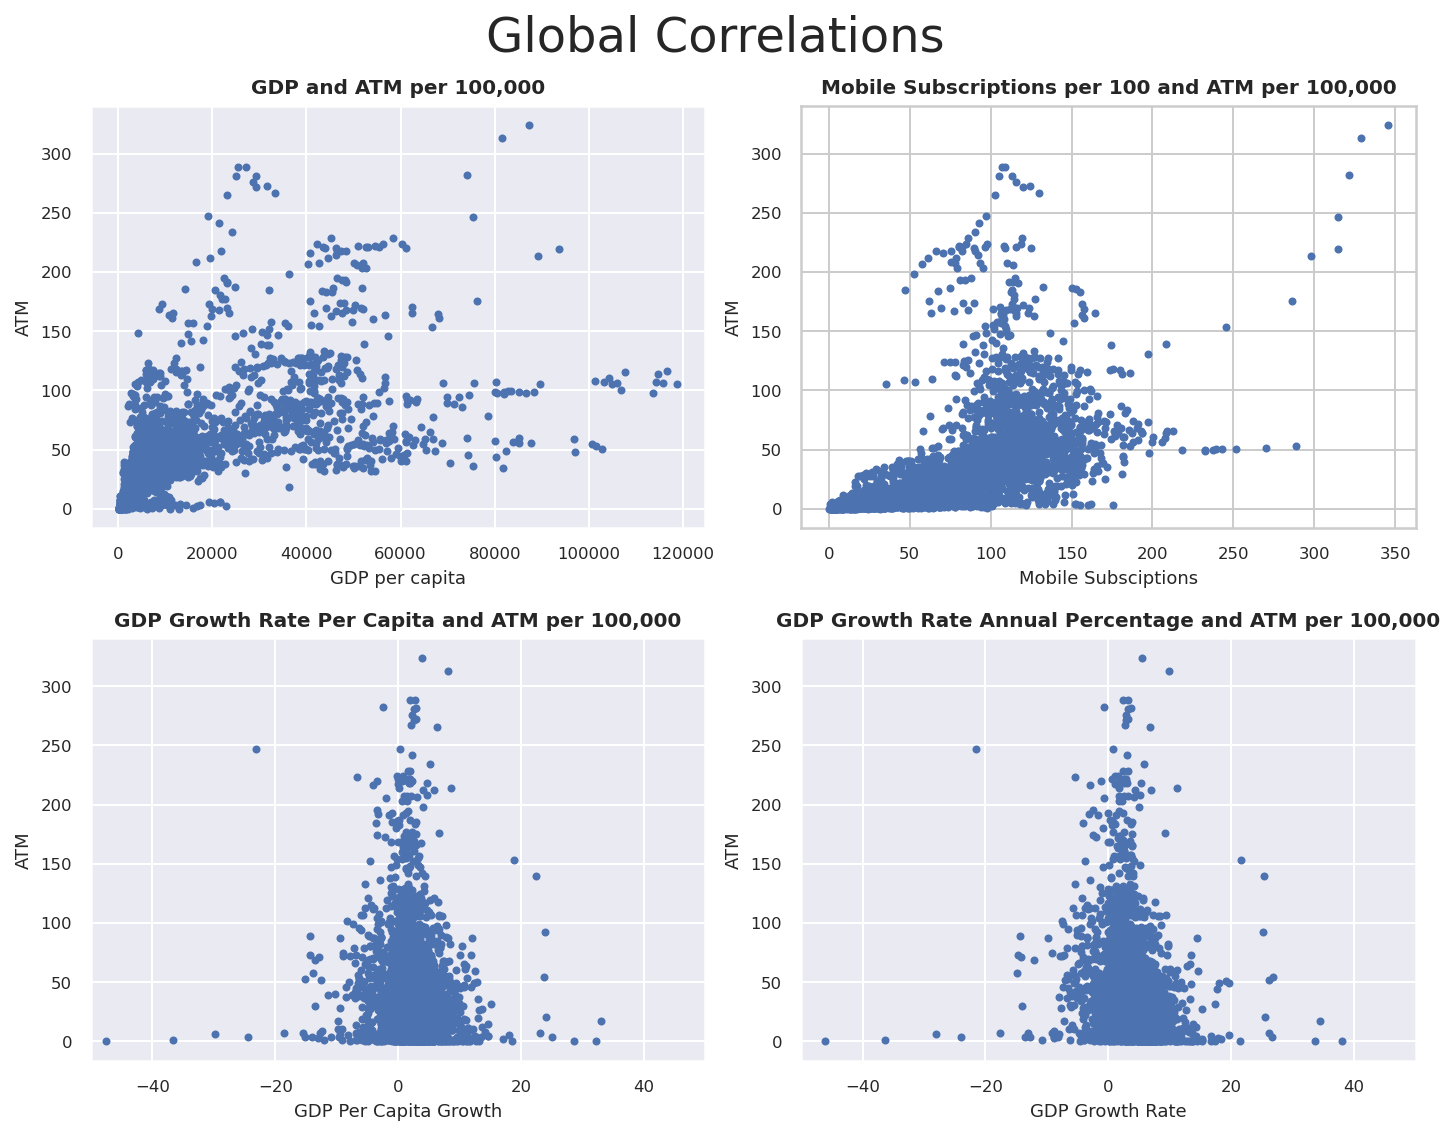

In [12]:
#SNS
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Global Correlations', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df.GDP_percapita, df.ATM_per100K, marker='.')
    _= ax0.set_xlabel('GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100,000', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df.mobile_subscr_per100, df.ATM_per100K, marker='.')
    _= ax1.set_xlabel('Mobile Subsciptions')
    _= ax1.set_ylabel('ATM')
    _= ax1.set_title('Mobile Subscriptions per 100 and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax2 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df.GDP_percapita_growth, df.ATM_per100K, marker='.')
    _= ax2.set_xlabel('GDP Per Capita Growth')
    _= ax2.set_ylabel('ATM')
    _= ax2.set_xlim([-50,50])
    _= ax2.set_title('GDP Growth Rate Per Capita and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df.GDP_growth_annualperc, df.ATM_per100K, marker='.')
    _= ax3.set_xlabel('GDP Growth Rate')
    _= ax3.set_ylabel('ATM')
    _= ax3.set_xlim([-50,50])
    _= ax3.set_title('GDP Growth Rate Annual Percentage and ATM per 100,000', weight='bold', size=10)

plt.subplots_adjust(wspace=1.5,hspace=1)
f.tight_layout()
# _= plt.savefig('World Correlations Scatter Matrix')

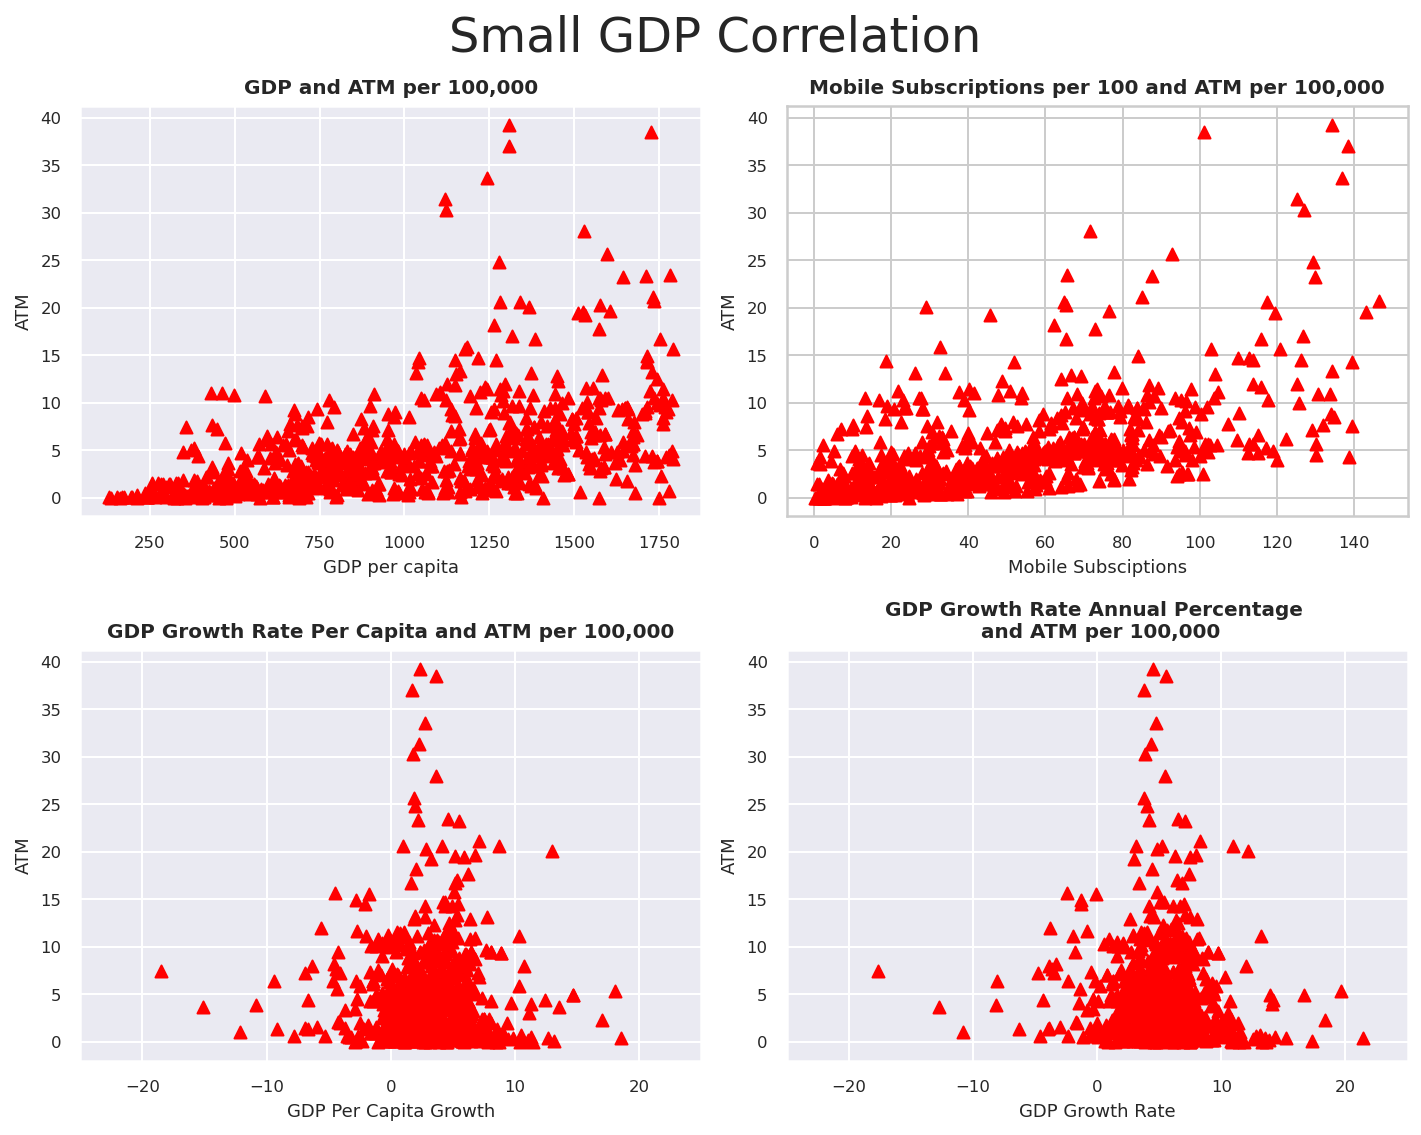

In [13]:
#Small GDP Feature Correlation
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Small GDP Correlation', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_small.GDP_percapita, df_small.ATM_per100K, marker='^', c = 'red')
    _= ax0.set_xlabel('GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100,000', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_small.mobile_subscr_per100, df_small.ATM_per100K, marker='^', c = 'red')
    _= ax1.set_xlabel('Mobile Subsciptions')
    _= ax1.set_ylabel('ATM')
    _= ax1.set_title('Mobile Subscriptions per 100 and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax2 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_small.GDP_percapita_growth, df_small.ATM_per100K, marker='^', c = 'red')
    _= ax2.set_xlabel('GDP Per Capita Growth')
    _= ax2.set_ylabel('ATM')
    _= ax2.set_xlim([-25,25])
    _= ax2.set_title('GDP Growth Rate Per Capita and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_small.GDP_growth_annualperc, df_small.ATM_per100K, marker='^', c = 'red')
    _= ax3.set_xlabel('GDP Growth Rate')
    _= ax3.set_ylabel('ATM')
    _= ax3.set_xlim([-25,25])
    _= ax3.set_title('GDP Growth Rate Annual Percentage \n and ATM per 100,000', weight='bold', size=10)

plt.subplots_adjust(wspace=1.5,hspace=1)
f.tight_layout()
# _= plt.savefig('Small GDP Correlations Scatter Matrix')

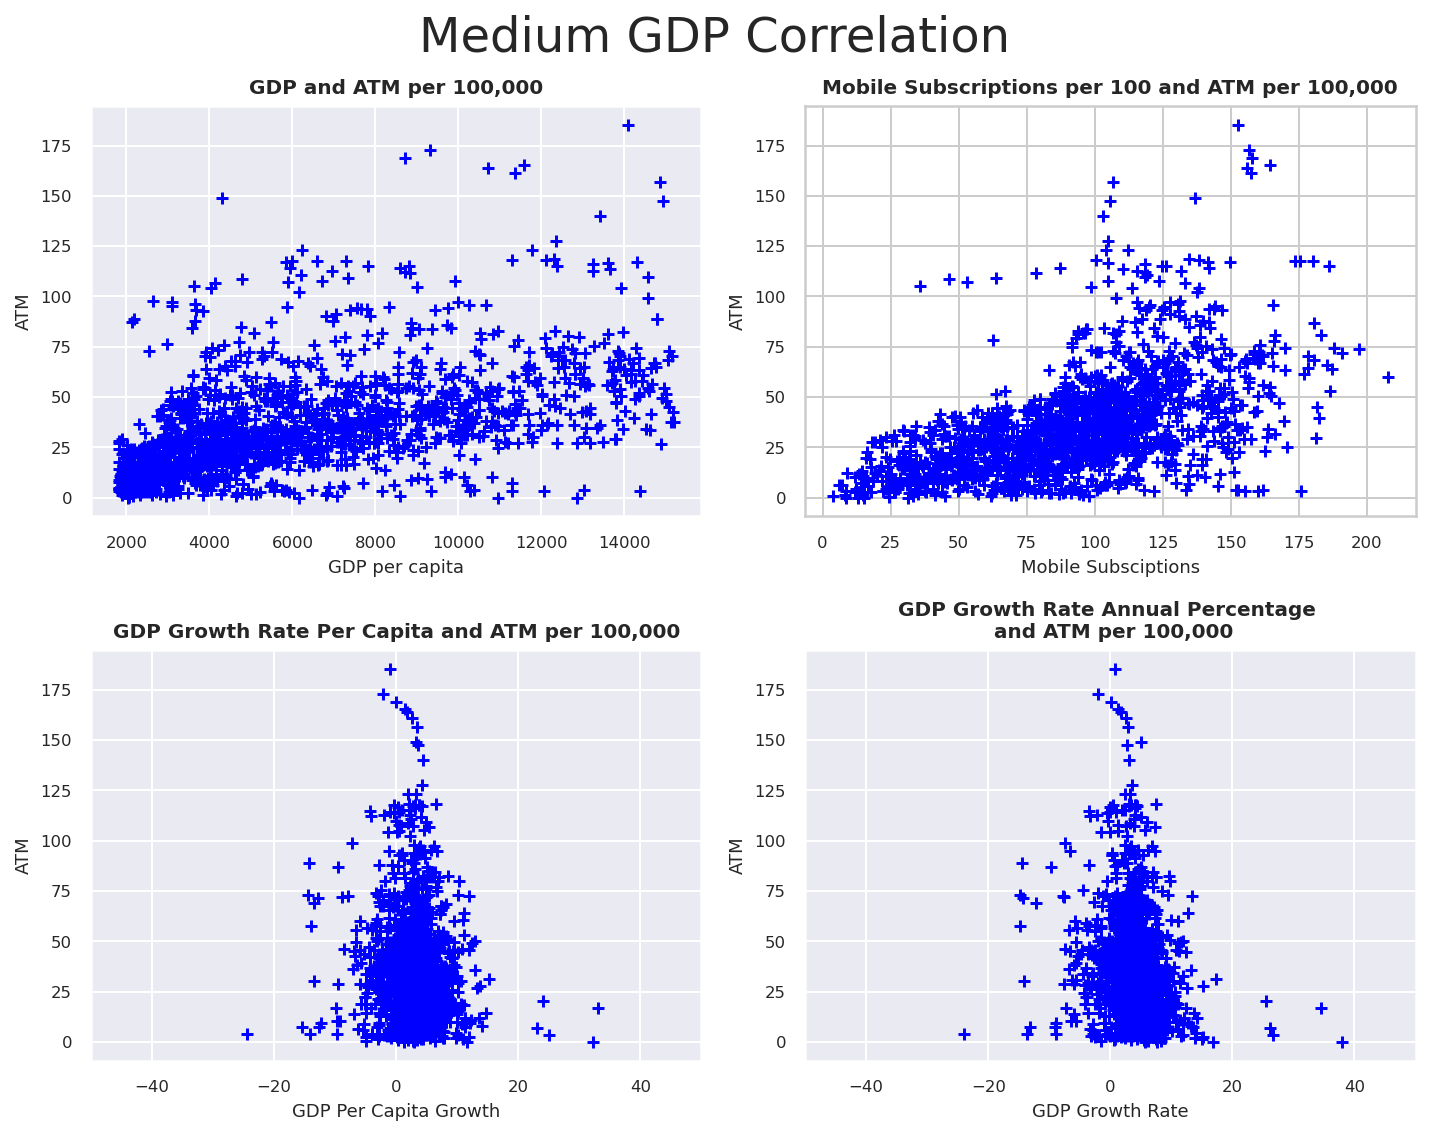

In [14]:
#Medium GDP Feature Correlation
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Medium GDP Correlation', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_medium.GDP_percapita, df_medium.ATM_per100K, marker='+', c = 'blue')
    _= ax0.set_xlabel('GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100,000', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_medium.mobile_subscr_per100, df_medium.ATM_per100K, marker='+', c = 'blue')
    _= ax1.set_xlabel('Mobile Subsciptions')
    _= ax1.set_ylabel('ATM')
    _= ax1.set_title('Mobile Subscriptions per 100 and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax2 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_medium.GDP_percapita_growth, df_medium.ATM_per100K, marker='+', c = 'blue')
    _= ax2.set_xlabel('GDP Per Capita Growth')
    _= ax2.set_ylabel('ATM')
    _= ax2.set_xlim([-50,50])
    _= ax2.set_title('GDP Growth Rate Per Capita and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_medium.GDP_growth_annualperc, df_medium.ATM_per100K, marker='+', c = 'blue')
    _= ax3.set_xlabel('GDP Growth Rate')
    _= ax3.set_ylabel('ATM')
    _= ax3.set_xlim([-50,50])
    _= ax3.set_title('GDP Growth Rate Annual Percentage \n and ATM per 100,000', weight='bold', size=10)

plt.subplots_adjust(wspace=1.5,hspace=1)
f.tight_layout()
# _= plt.savefig('Medium GDP Correlations Scatter Matrix')

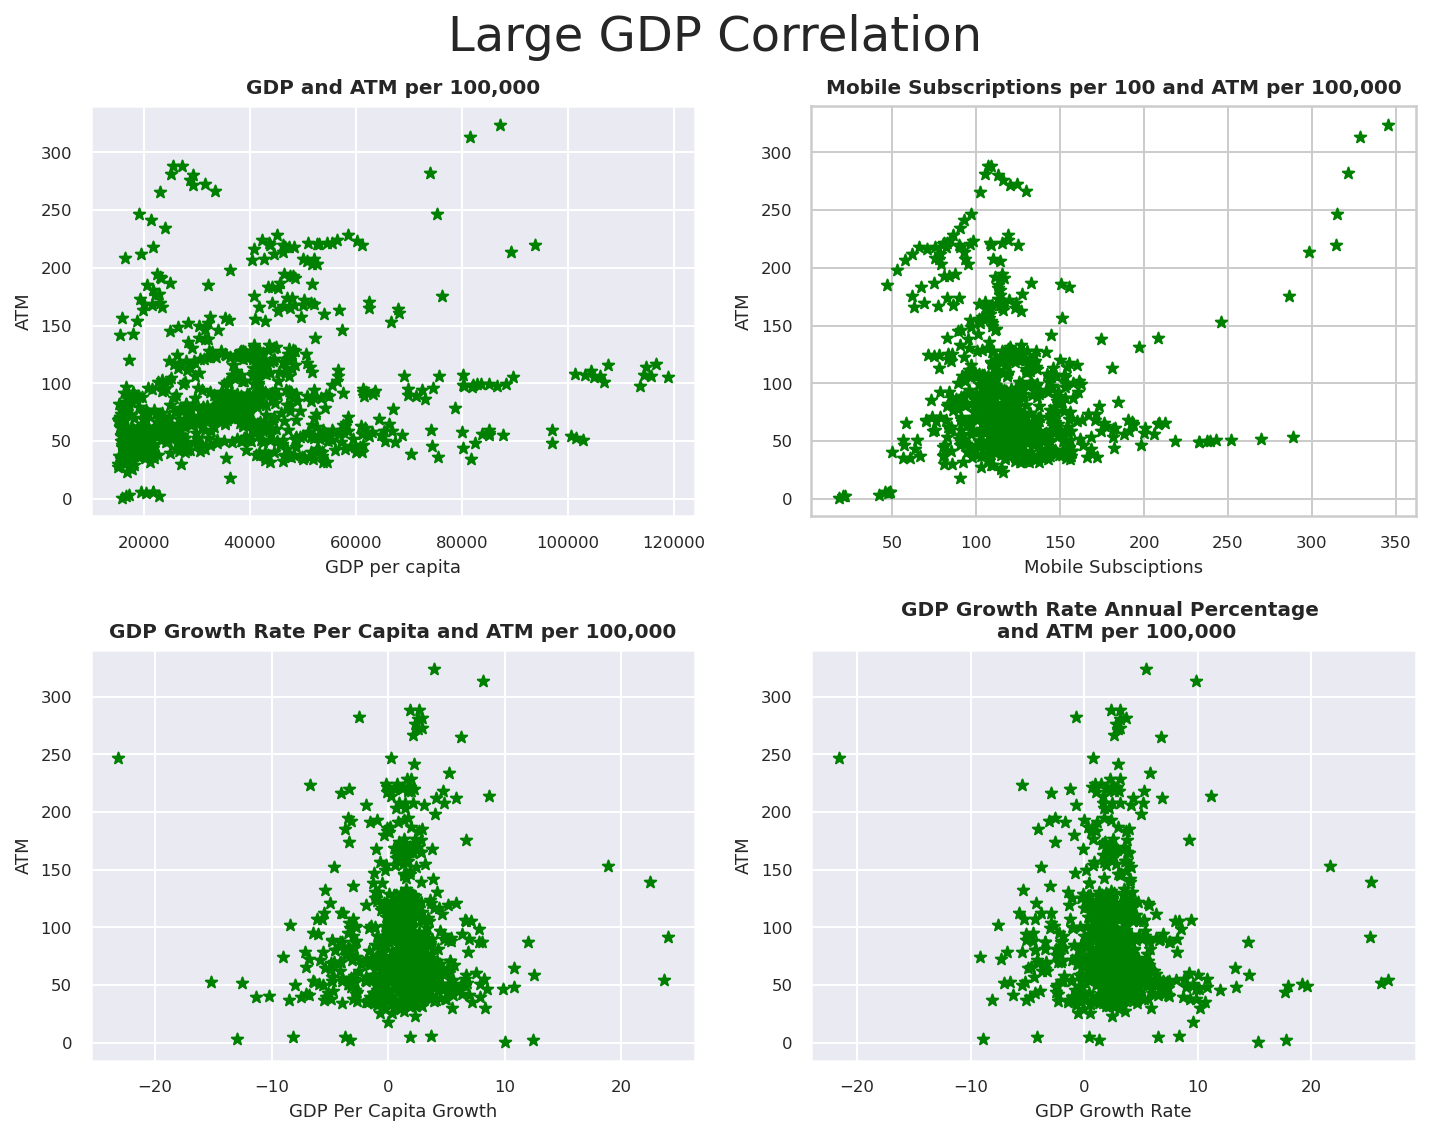

In [15]:
#Large GDP Feature Correlation
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Large GDP Correlation', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_large.GDP_percapita, df_large.ATM_per100K, marker='*', c = 'green')
    _= ax0.set_xlabel('GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100,000', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_large.mobile_subscr_per100, df_large.ATM_per100K, marker='*', c = 'green')
    _= ax1.set_xlabel('Mobile Subsciptions')
    _= ax1.set_ylabel('ATM')
    _= ax1.set_title('Mobile Subscriptions per 100 and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax2 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_large.GDP_percapita_growth, df_large.ATM_per100K, marker='*', c = 'green')
    _= ax2.set_xlabel('GDP Per Capita Growth')
    _= ax2.set_ylabel('ATM')
    _= ax2.set_title('GDP Growth Rate Per Capita and ATM per 100,000', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_large.GDP_growth_annualperc, df_large.ATM_per100K, marker='*', c = 'green')
    _= ax3.set_xlabel('GDP Growth Rate')
    _= ax3.set_ylabel('ATM')
    _= ax3.set_title('GDP Growth Rate Annual Percentage \n and ATM per 100,000', weight='bold', size=10)

plt.subplots_adjust(wspace=1.5,hspace=1)
f.tight_layout()
# _= plt.savefig('Large GDP Correlations Scatter Matrix')

In [16]:
world_part_regress = sfm.ols(formula="ATM_per100K ~ GDP_growth_annualperc + GDP + GDP_percapita + GDP_percapita_growth + mobile_subscr_per100", data=df).fit()
world_part_regress.params
world_part_regress.summary()

Intercept                1.456224e+01
GDP_growth_annualperc   -6.475572e+00
GDP                      7.387647e-14
GDP_percapita            1.270314e-03
GDP_percapita_growth     6.170803e+00
mobile_subscr_per100     2.282848e-01
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     696.1
Date:                Fri, 30 Oct 2020   Prob (F-statistic):               0.00
Time:                        04:25:09   Log-Likelihood:                -15481.
No. Observations:                3197   AIC:                         3.097e+04
Df Residuals:                    3191   BIC:                         3.101e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.5622      1.598      9.112      0.000      11.429      17.696
GDP_growth_annualperc    -6.4756      0.372    -17.397      0.000      -7.205      -5.746
GDP                    7.388e-14   6.72e-14      1.099      0.272   -5.79e-14    2.06e-13
GDP_percapita             0.0013   3.45e-05     36.785      0.000       0.001       0.001
GDP_percapita_growth      6.1708      0.377     16.370      0.000       5.432       6.910
mobile_subscr_per100      0.2283      0.015     15.519      0.000       0.199       0.257
==============================================================================
Omnibus:                     1663.592   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18433.432
Skew:                           2.225   Prob(JB):                         0.00
Kurtosis:                      13.889   Cond. No.                     2.56e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

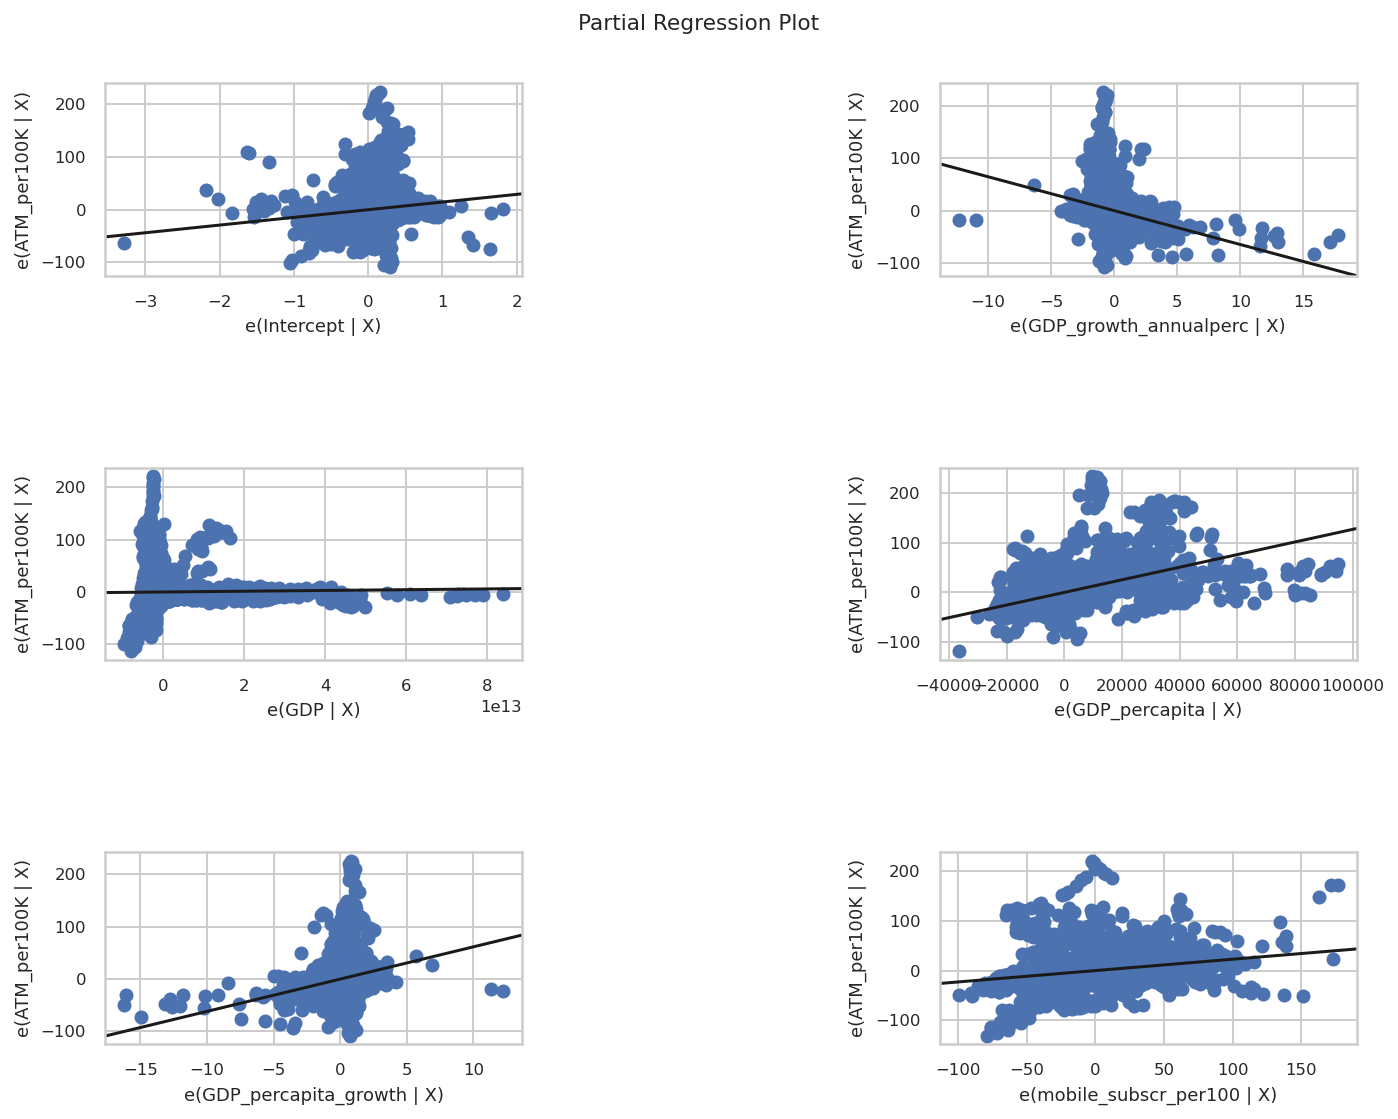

In [17]:
#Partial Regression on world data
fig = plt.figure(figsize=(10,8)) 
with sns.axes_style("whitegrid"):
    ax = sm.graphics.plot_partregress_grid(world_part_regress, fig=fig)
fig.tight_layout(pad=2)
plt.subplots_adjust(wspace=1,hspace=1) 
# _= plt.savefig('World Correlations Scatter - Partial Regression')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     148.0
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           2.61e-33
Time:                        04:25:42   Log-Likelihood:                -16587.
No. Observations:                3197   AIC:                         3.318e+04
Df Residuals:                    3195   BIC:                         3.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    49.3088      0.985     50.047      0.000      47.377      51.241
GDP_growth_annualperc    -1.9399      0.159    -12.164      0.000      -2.253      -1.627
==============================================================================
Omnibus:                     1404.806   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7595.296
Skew:                           2.056   Prob(JB):                         0.00
Kurtosis:                       9.333   Cond. No.                         8.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/conda/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

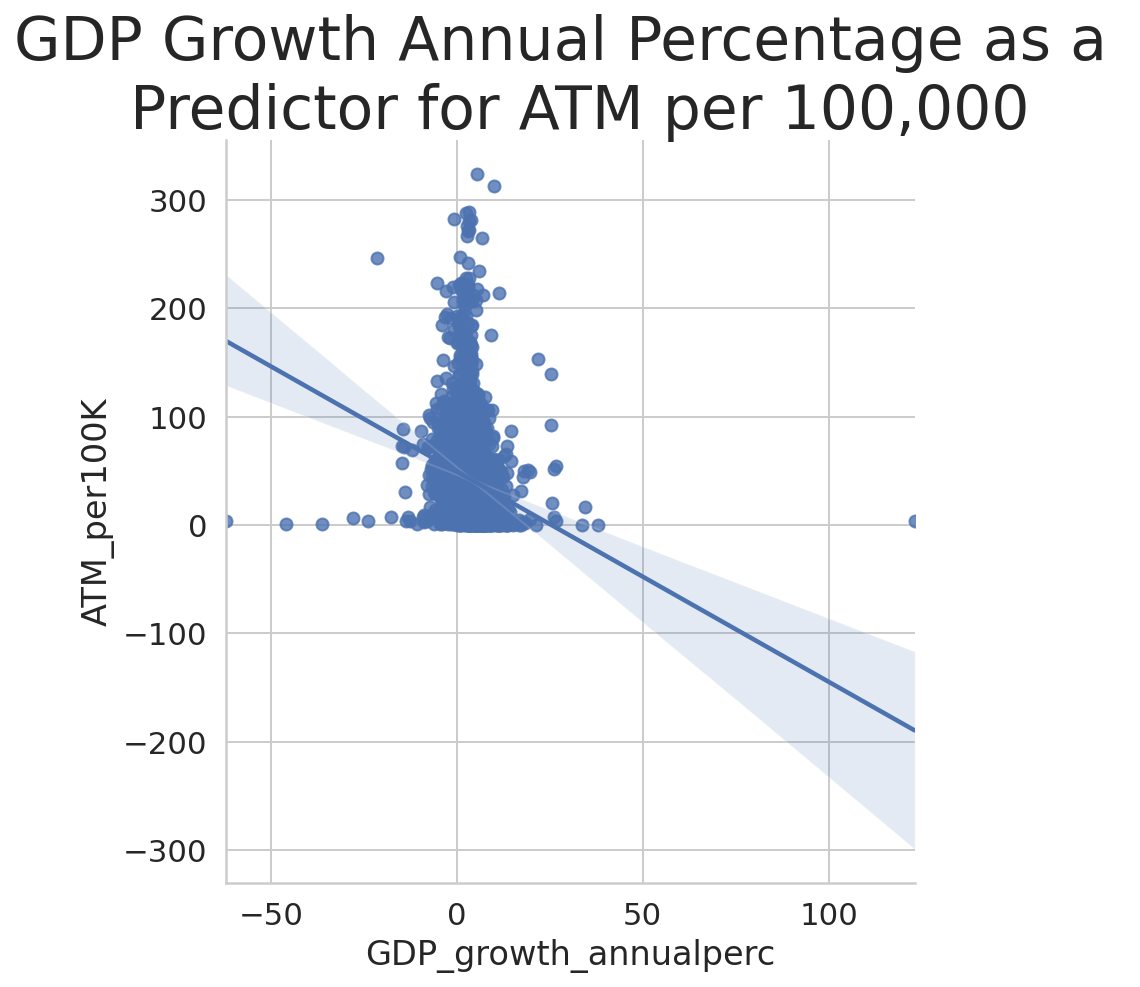

In [19]:
df.dropna(inplace=True)
fig = plt.figure(figsize=(10,8)) 
X = df['GDP_growth_annualperc']
Y = df['ATM_per100K']
model = sm.OLS(Y,sm.add_constant(X), data=df)
model_fit = model.fit()
model_fit.summary()


#Seaborn
sns.set(font_scale=1.4,style="whitegrid")
ax = sns.lmplot(x='GDP_growth_annualperc', y='ATM_per100K', data=df, size=6)
_= plt.title('GDP Growth Annual Percentage as a \n Predictor for ATM per 100,000', fontsize=30)
_= plt.rc('xtick', labelsize=15)
_= plt.rc('ytick', labelsize=15)
# plt.savefig('GDP Growth Annual Percentage as a Predictor for ATM per 100,000', bbox_inches='tight')

<ipython-input-20-c86a762ad824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.dropna(inplace=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.509
Date:                Fri, 30 Oct 2020   Prob (F-statistic):             0.0340
Time:                        04:25:51   Log-Likelihood:                -4311.8
No. Observations:                 802   AIC:                             8628.
Df Residuals:                     800   BIC:                             8637.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    92.7356      2.186     42.421      0.000      88.445      97.027
GDP_growth_annualperc    -1.0190      0.480     -2.123      0.034      -1.961      -0.077
==============================================================================
Omnibus:                      230.266   Durbin-Watson:                   0.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.852
Skew:                           1.543   Prob(JB):                    1.19e-116
Kurtosis:                       5.540   Cond. No.                         5.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/conda/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

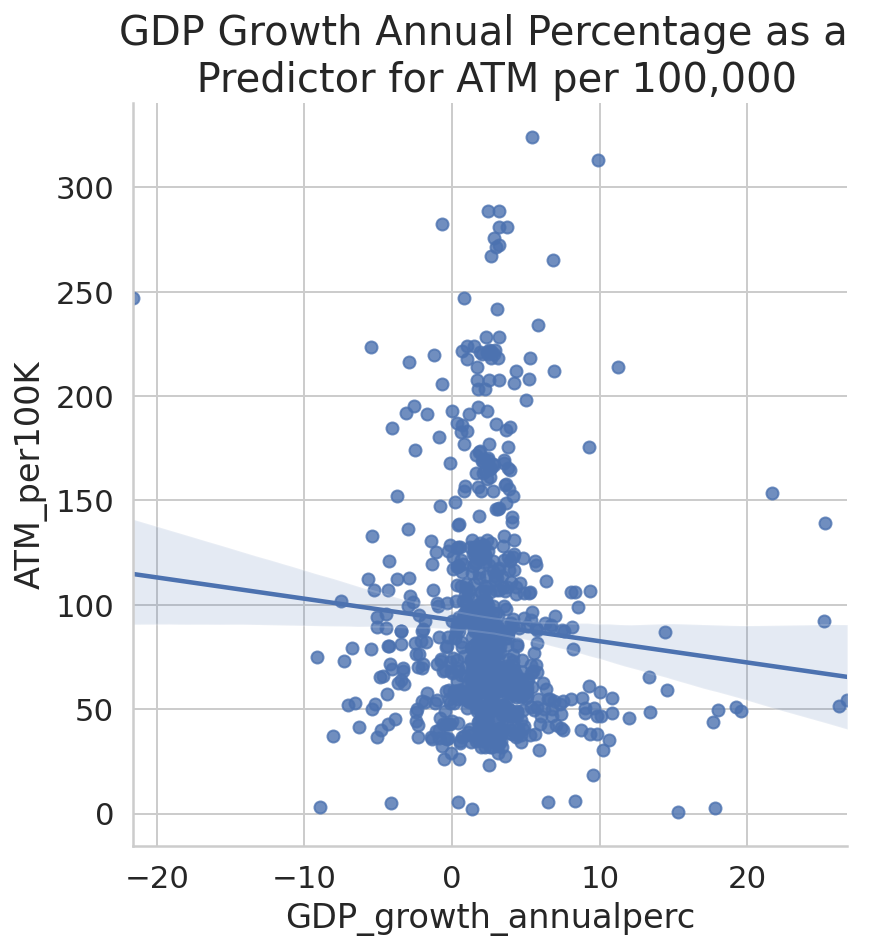

In [20]:
df_small.dropna(inplace=True)
fig = plt.figure(figsize=(10,8)) 
X = df_large['GDP_growth_annualperc']
Y = df_large['ATM_per100K']
model2 = sm.OLS(Y,sm.add_constant(X), data=df)
model_fit = model2.fit()
model_fit.summary()

#Seaborn
_= sns.set(font_scale=1.4,style="whitegrid")
ax = sns.lmplot(x='GDP_growth_annualperc', y='ATM_per100K', data=df_large, size=6)
_= plt.rc('xtick', labelsize=15)
_= plt.rc('ytick', labelsize=15)
_= plt.title('GDP Growth Annual Percentage as a \n Predictor for ATM per 100,000', fontsize=20)
# plt.savefig('Large GDP Growth Annual Percentage as a Predictor for ATM per 100,000', bbox_inches='tight')

In [22]:
small_part_regress = sfm.ols(formula="ATM_per100K ~ GDP_growth_annualperc + GDP + GDP_percapita + GDP_percapita_growth + mobile_subscr_per100", data=df_small).fit()
small_part_regress.params
small_part_regress.summary()

Intercept               -3.466980e-01
GDP_growth_annualperc   -7.074881e-01
GDP                     -2.917535e-13
GDP_percapita            3.359531e-03
GDP_percapita_growth     7.500641e-01
mobile_subscr_per100     6.994324e-02
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     127.4
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           7.81e-99
Time:                        04:26:06   Log-Likelihood:                -2173.5
No. Observations:                 793   AIC:                             4359.
Df Residuals:                     787   BIC:                             4387.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3467      0.531     -0.653      0.514      -1.389       0.696
GDP_growth_annualperc    -0.7075      0.130     -5.459      0.000      -0.962      -0.453
GDP                   -2.918e-13   1.71e-13     -1.710      0.088   -6.27e-13    4.32e-14
GDP_percapita             0.0034      0.000      8.797      0.000       0.003       0.004
GDP_percapita_growth      0.7501      0.129      5.806      0.000       0.496       1.004
mobile_subscr_per100      0.0699      0.004     15.546      0.000       0.061       0.079
==============================================================================
Omnibus:                      507.528   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7382.304
Skew:                           2.667   Prob(JB):                         0.00
Kurtosis:                      16.964   Cond. No.                     3.79e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.79e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
medium_part_regress = sfm.ols(formula="ATM_per100K ~ GDP_growth_annualperc + GDP + GDP_percapita + GDP_percapita_growth + mobile_subscr_per100", data=df_medium).fit()
medium_part_regress.params
medium_part_regress.summary()

Intercept                7.327849e+00
GDP_growth_annualperc   -5.785072e+00
GDP                     -1.186558e-13
GDP_percapita            2.228381e-03
GDP_percapita_growth     5.560716e+00
mobile_subscr_per100     2.364619e-01
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     259.0
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          6.50e-203
Time:                        04:26:11   Log-Likelihood:                -6983.3
No. Observations:                1602   AIC:                         1.398e+04
Df Residuals:                    1596   BIC:                         1.401e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.3278      1.614      4.541      0.000       4.162      10.493
GDP_growth_annualperc    -5.7851      0.421    -13.735      0.000      -6.611      -4.959
GDP                   -1.187e-13   5.71e-14     -2.078      0.038   -2.31e-13   -6.67e-15
GDP_percapita             0.0022      0.000     14.018      0.000       0.002       0.003
GDP_percapita_growth      5.5607      0.421     13.212      0.000       4.735       6.386
mobile_subscr_per100      0.2365      0.015     15.508      0.000       0.207       0.266
==============================================================================
Omnibus:                      644.872   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3801.867
Skew:                           1.784   Prob(JB):                         0.00
Kurtosis:                       9.650   Cond. No.                     3.03e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
large_part_regress = sfm.ols(formula="ATM_per100K ~ GDP_growth_annualperc + GDP + GDP_percapita + GDP_percapita_growth + mobile_subscr_per100", data=df_large).fit()
large_part_regress.params
large_part_regress.summary()

Intercept                8.101406e+01
GDP_growth_annualperc   -5.351161e+00
GDP                     -7.096606e-14
GDP_percapita            6.030191e-04
GDP_percapita_growth     5.308740e+00
mobile_subscr_per100    -6.010742e-02
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     12.96
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           3.86e-12
Time:                        04:26:15   Log-Likelihood:                -4282.6
No. Observations:                 802   AIC:                             8577.
Df Residuals:                     796   BIC:                             8605.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                81.0141      7.321     11.067      0.000      66.644      95.384
GDP_growth_annualperc    -5.3512      0.881     -6.073      0.000      -7.081      -3.621
GDP                   -7.097e-14   1.67e-13     -0.425      0.671   -3.98e-13    2.57e-13
GDP_percapita             0.0006   9.55e-05      6.311      0.000       0.000       0.001
GDP_percapita_growth      5.3087      0.951      5.585      0.000       3.443       7.175
mobile_subscr_per100     -0.0601      0.052     -1.150      0.250      -0.163       0.042
==============================================================================
Omnibus:                      237.763   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.936
Skew:                           1.563   Prob(JB):                    7.10e-127
Kurtosis:                       5.758   Cond. No.                     4.83e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""